In [2]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr


In [3]:
from random import randint, choice
from time import time
import re
import csv
from pathlib import Path
import glob

from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from exp_utils import JeongganProcessor, JeongganSynthesizer

# Synthesized Dataset

## PATHS

In [3]:
img_path_base = 'test/synth/src/'
img_path_sub = ['notes/']
img_ext = '.png'

img_paths = { 
  subpath[:-1]: {
    path.replace(f'{img_path_base}{subpath}', '').replace(img_ext, ''): path \
    for path in glob.glob(f'{img_path_base}{subpath}*{img_ext}')
  } for subpath in img_path_sub 
}

# print([ name for name in img_paths['notations'].keys() ])
print(sorted([ name for name in img_paths['notes'].keys() ]))

note_paths = {}

for name, path in sorted(img_paths['notes'].items(), key=lambda x: x[0]):
  name = re.sub(r'(_\d\d\d)|(_ot)', '', name)
  
  if note_paths.get(name, False):
    note_paths[name].append(path)
  else:
    note_paths[name] = [path]

for name, paths in note_paths.items():
  if len(paths) < 2:
    note_paths[name] = paths[0]

['conti_001', 'conti_002', 'ee', 'ee_dd', 'eung', 'eung_d', 'go', 'go_d', 'go_u', 'hwang', 'hwang_d', 'hwang_d_ot', 'hwang_dd_ot', 'hwang_ot', 'hwang_u', 'hwang_u_ot', 'hwang_uu', 'hyeop', 'hyeop_d', 'hyeop_dd', 'hyeop_u', 'joong', 'joong_d', 'joong_dd', 'joong_u', 'lim', 'lim_d', 'lim_dd', 'lim_ddd', 'lim_u', 'mu', 'mu_d', 'mu_dd', 'mu_u', 'nam', 'nam_d', 'nam_dd', 'nam_u', 'pause', 'tae', 'tae_d', 'tae_dd', 'tae_u']


## TEST: Synthesizer 

'황:1 황:3 배무:4 배남:6 배무:7 배무:9'

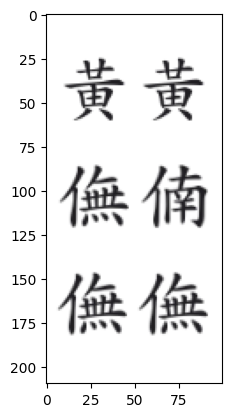

In [4]:
jng_synth = JeongganSynthesizer(note_paths)

jng_label, jng_img = jng_synth()

plt.imshow(jng_img, interpolation=None)
jng_label

태:10 배응:14 -:15


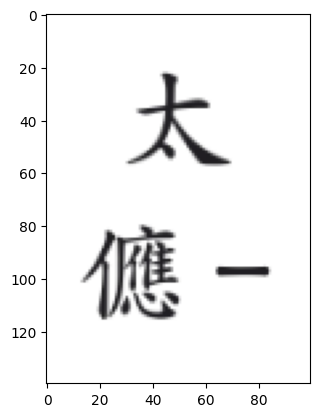

In [7]:
jng_synth = JeongganSynthesizer(note_paths)

_, label = jng_synth.get_label_dict()
print(label)

jng_img = jng_synth.generate_image_by_label(label)

plt.imshow(jng_img, interpolation=None)

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:12<00:00, 77938.47it/s]


<BarContainer object of 15 artists>

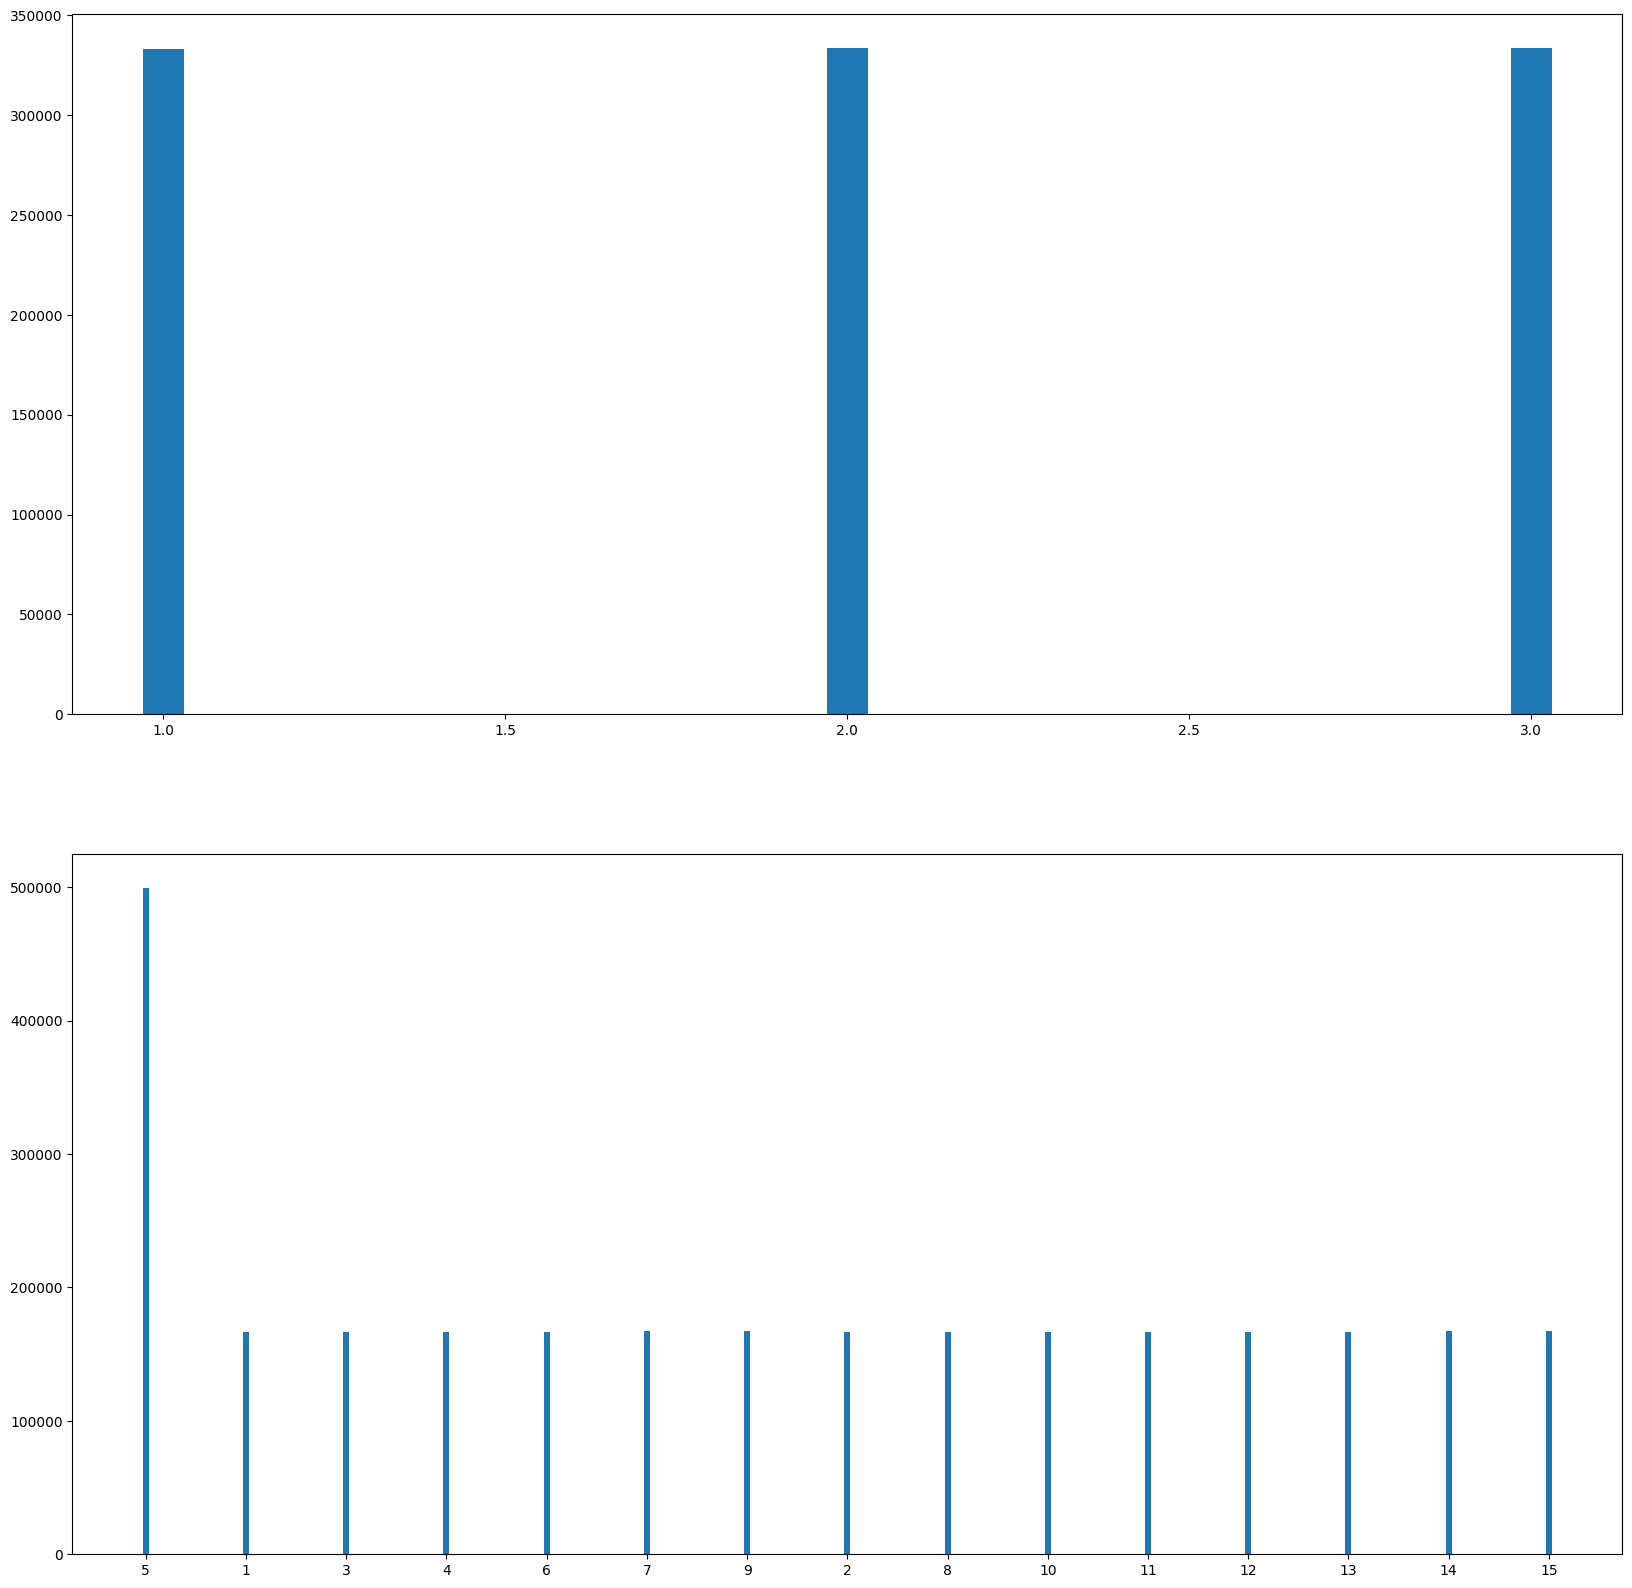

In [229]:
from collections import Counter

positions = []
row_divs = []

for _ in tqdm(range(1_000_000)):
  _, label = JeongganSynthesizer.get_label_dict()
  
  pattern = r'([^_\s:]+|_+[^_\s:]+|[^:]\d+|[-])'
    
  notes = label.split()
  
  poses = []
  
  for note in notes:
    findings = re.findall(pattern, note)
    poses.append( findings[-1] )
  
  row_div = JeongganProcessor.get_row_div( list( map(int, poses) ) )
  
  row_divs.append(row_div)
  positions += poses

row_div_cnt = Counter(row_divs)
position_cnt = Counter(positions)

plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
plt.bar(row_div_cnt.keys(), row_div_cnt.values(), 0.06)

plt.subplot(2, 1, 2)
plt.bar(position_cnt.keys(), position_cnt.values(), 0.06)

## num of possible JNG combinations

In [183]:
from exp_utils import PITCH_ORDER, OCTAVE_WIDTH

num_marks = 2
num_octave_range = len(PITCH_ORDER) - OCTAVE_WIDTH
num_choices = OCTAVE_WIDTH + num_marks

num_col_variants = num_choices + pow(num_choices, 2)

num_octave_range * ( num_choices + pow(num_col_variants, 2) + pow(num_col_variants, 3) )

137547504

## train set (synth)

* JeongganSynthesizer.generate_single_data() takes 0.0006 sec
* 0.0006 * 1,000,000 = 600 (10min)
* average 3.1% fail rate

In [285]:
from time import time

NUM_RECIPE = 1_000_000

fail_cnt = 0

with open(f'test/data/train/002_{int(time())}.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
    
  for _ in tqdm(range(NUM_RECIPE)):
    
    while True:
      try:
        label, width, height = jng_synth.generate_single_data()
        writer.writerow([label, width, height])
        break
      
      except:
        fail_cnt += 1

fail_cnt

100%|██████████| 1000000/1000000 [09:21<00:00, 1781.08it/s]


31922

## validation set (synth)

In [8]:
from time import time

NUM_RECIPE = 1_000

fail_cnt = 0

with open(f'test/data/valid/002_{int(time())}.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
    
  for _ in tqdm(range(NUM_RECIPE)):
    
    while True:
      try:
        label, width, height = jng_synth.generate_single_data()
        writer.writerow([label, width, height])
        break
      
      except:
        fail_cnt += 1

fail_cnt

100%|██████████| 1000/1000 [00:00<00:00, 1767.00it/s]


32

## tests

In [16]:
train_data_filenames = ['001_1706859356', '002_1706860394']
valid_data_filenames = ['001_1706861315', '002_1706941333']

train_data_list = []

for data_filename in train_data_filenames:
  with open(f'test/data/train/{data_filename}.csv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    train_data_list.append(list(reader))

valid_data_list = []
for data_filename in valid_data_filenames:
  with open(f'test/data/valid/{data_filename}.csv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    valid_data_list.append((reader))

### duplications in train data
* about 40% in single csv

In [33]:
train_data_list = [ list(map(tuple, train_data ) )for train_data in train_data_list ]

for idx, train_data in enumerate(train_data_list):
  print(idx+1, len(train_data) == len(set(train_data)), len(set(train_data)))

1 False 606471
2 False 606275


### duplication counts between train and valid set
**average 43%**

* t-1 and v-1: 460
* t-1 and v-2: 413
* t-2 and v-1: 457
* t-2 and v-2: 422

In [35]:
res = []

for valid_data in valid_data_list:
  dup_list = []
  for train_data in train_data_list:
    dup_cnt = 0
    for data in valid_data:
      data = tuple(data)
      if data in train_data:
        dup_cnt += 1
    
    dup_list.append(dup_cnt)
  
  res.append(dup_list)

res

[[460, 457], [413, 422]]

### image generation from recipe

('하배중:12 쉼표:13 하배황:14 하배황:15', '206', '103', (206, 103))

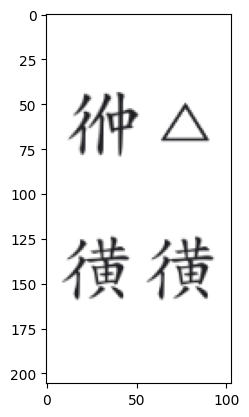

In [14]:
label, width, height = label_list[78]
jng_img = jng_synth.generate_image_by_label(label, int(width), int(height))

plt.imshow(jng_img)

label, height, width, jng_img.shape[:2]

## test set (synth)

In [3]:
# load dup test targets
train_data_filename = '001_1706859356'
valid_data_filename = '001_1706861315'

with open(f'data/train/{train_data_filename}.csv', 'r', newline='', encoding='utf-8') as f:
  reader = csv.reader(f)
  train_data = list(reader)


with open(f'data/valid/{valid_data_filename}.csv', 'r', newline='', encoding='utf-8') as f:
  reader = csv.reader(f)
  valid_data = list(reader)

In [4]:
train_data = set(list(map(tuple, train_data)))
valid_data = set(list(map(tuple, valid_data)))

('배협:1 배임:3 배중:5 -:7 배태:9', 153, 102, (153, 102))

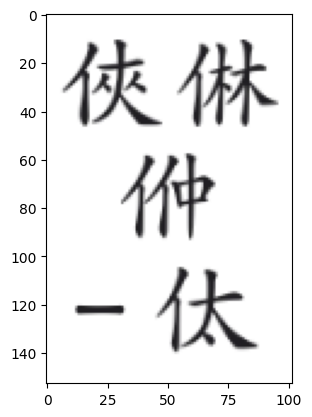

In [15]:
label, width, height = jng_synth.generate_single_data(is_test=True)
img = jng_synth.generate_image_by_label(label, width, height)

plt.imshow(img)
label, height, width, img.shape[:2]

In [16]:
NUM_RECIPE = 1_000

fail_cnt = 0

with open(f'data/test/001_{int(time())}.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
    
  for _ in tqdm(range(NUM_RECIPE)):
    
    while True:
      try:
        label, width, height = jng_synth.generate_single_data(is_test=True)
        
        if (label, width, height) in train_data and (label, width, height) in valid_data:
          raise
        
        writer.writerow([label, width, height])
        break
      
      except:
        fail_cnt += 1

fail_cnt

100%|██████████| 1000/1000 [00:00<00:00, 1747.20it/s]


36

## validation set (HL)

## test set (HL) - w/o ornamentations
**391 data**

In [26]:
with open('test/labels_from_label_studio_1702625955.csv', 'r', newline='', encoding='utf-8') as f:
  hl_list_raw = list(csv.reader(f))[1:]

with open(f'data/test/001_HL_{int(time())}.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
  
  for hl_row in hl_list_raw:
    filename, *_, label = hl_row
    
    if any(orn in label for orn in ['노', '니', '로', '리', '니나', '느나', '노라', '느니', '나니나', '_']):
      continue
    
    writer.writerow([filename, label])

## test

### with Synthesized Testset

In [21]:
from omr_cnn import Inferencer

test_data_filename = '001_1707094232'

with open(f'data/test/{test_data_filename}.csv', 'r', newline='', encoding='utf-8') as f:
  reader = csv.reader(f)
  test_data = list(reader)

inferencer = Inferencer(vocab_txt_fn='data/001_tokenizer.txt', model_weights='model/synth_only_240204_001_best.pt')

with open(f'data/test/{test_data_filename}_result.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
  writer.writerow(['label', 'pred', 'width', 'height'])
  
  for data in tqdm(test_data):
    label, width, height = data
    img = jng_synth.generate_image_by_label(label, int(width), int(height))
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    
    pred_label = inferencer(img)
    
    writer.writerow([label, pred_label, width, height])


100%|██████████| 1000/1000 [00:14<00:00, 68.78it/s]


### with HL Testset (without ornamentations)

In [35]:
from omr_cnn import Inferencer

test_data_filename = '001_HL_1707193340'

test_img_path = Path('test/split_pngs/')

with open(f'data/test/{test_data_filename}.csv', 'r', newline='', encoding='utf-8') as f:
  testset = list(csv.reader(f))

inferencer = Inferencer(vocab_txt_fn='data/001_tokenizer.txt', model_weights='model/synth_only_240204_001_best.pt')

with open(f'data/test/{test_data_filename}_result.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
  writer.writerow(['label', 'pred', 'filename'])
  
  for data in tqdm(testset):
    img_name, label = data
    img_path = str(test_img_path / img_name)
  
    pred_label = inferencer(img_path)
    
    writer.writerow([label, pred_label, img_name])

/home/dongmin/.local/share/virtualenvs/jeongganbo-omr-ftFKYzOH/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/321 [00:00<?, ?it/s]

/home/dongmin/.local/share/virtualenvs/jeongganbo-omr-ftFKYzOH/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 321/321 [00:05<00:00, 63.53it/s]


In [29]:
def get_notes_and_positions(label):
  pattern = r'([^_\s:]+|_+[^_\s:]+|[^:]\d+|[-])'
    
  token_groups = label.split()
  
  notes = []
  positions = []
  
  for group in token_groups:
    findings = re.findall(pattern, group)
    notes.append(findings[0])
    positions.append(findings[-1])
  
  return notes, positions

split_octave_and_pclass = lambda string: re.findall(r'(배|하배|하하배|청|중청)?(.+)', string)[0]

In [45]:
test_data_filename = '001_HL_1707193340'

with open(f'data/test/{test_data_filename}_result.csv', 'r', newline='', encoding='utf-8') as f:
  reader = csv.reader(f)
  test_results = list(reader)[1:]

len_result = len(test_results)
cnts = [0, 0, 0, 0] # [exact, position, notes, length]

length_match_token_cnt = 0
add_cnts = [0, 0] # [exact, pclass]

idx = 0

for result in test_results:
  label, pred_label, *_ = result
  
  if label == pred_label:
    cnts[0] += 1
  
  label_notes, label_positions = get_notes_and_positions(label)
  pred_label_notes, pred_label_positions = get_notes_and_positions(pred_label)
  
  if len(label_notes) == len(pred_label_notes):
    cnts[3] += 1
    length_match_token_cnt += len(label_notes)
    
    for note, hnote in zip(label_notes, pred_label_notes):
      note_oct, note_pc = split_octave_and_pclass(note)
      hnote_oct, hnote_pc = split_octave_and_pclass(hnote)
      
      if note_oct == hnote_oct and note_pc == hnote_pc:
        add_cnts[0] += 1
        
      if note_pc == hnote_pc:
        add_cnts[1] += 1
  
  
  if label_positions == pred_label_positions:
    cnts[1] += 1
  
  if label_notes == pred_label_notes:
    cnts[2] += 1

print_items = ['exact', 'pos', 'note', 'length']

for item, cnt in zip(print_items, cnts):
  print(f'Acc_{item}: {cnt/len_result}')

print()

for item, cnt in zip(['note_exact', 'note_pcalss'], add_cnts):
  print(f'Acc_{item}: {cnt/length_match_token_cnt}')

Acc_exact: 0.11838006230529595
Acc_pos: 0.21495327102803738
Acc_note: 0.11838006230529595
Acc_length: 0.22118380062305296

Acc_note_exact: 0.8405797101449275
Acc_note_pcalss: 0.8731884057971014


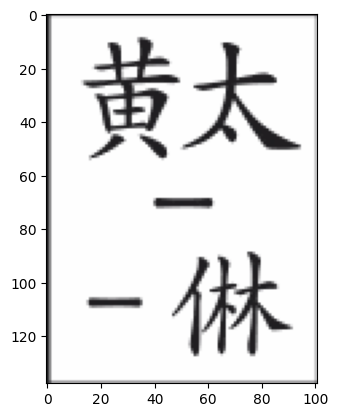

In [6]:
filename = '남창계면-두거_haegeum_35'
plt.imshow(cv2.imread(f'test/split_pngs/{filename}.png'))